In [3]:
import numpy as np
from skimage import filters, io
import cv2 as cv
from matplotlib import pyplot as plt
from scipy.ndimage import maximum_filter
from skimage.feature import corner_harris, corner_peaks

from myfunc.mysubplot import subplots

### Step1: Image gradients

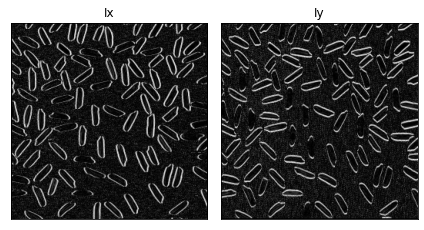

In [4]:
image = io.imread(fname="../../data/ass3/rice.png")
h,w = image.shape
# keep the output datatype to some higher forms
Ix = cv.Sobel(image,cv.CV_64F,1,0,ksize=1)
abs_Ix = np.absolute(Ix)
Ix_8u = np.uint8(abs_Ix)
Iy = cv.Sobel(image,cv.CV_64F,0,1,ksize=1)
abs_Iy = np.absolute(Iy)
Iy_8u = np.uint8(abs_Iy)

subplots([Ix_8u, Iy_8u], ['Ix', 'Iy'], 1,2)

### Step2: Second movement matrix M 

In [5]:
# Gaussian truncate window
kernel_size = 3
sigma = 0.5
Ixx = cv.GaussianBlur(Ix**2,(kernel_size,kernel_size), sigma)
Ixy = cv.GaussianBlur(Ix*Iy,(kernel_size,kernel_size), sigma)
Iyy = cv.GaussianBlur(Iy**2,(kernel_size,kernel_size), sigma)

### Step3: Compute corner response function R

In [6]:
offset = np.int8(kernel_size/2)
height, width = image.shape
corner_response = np.zeros((height, width))

# construct matrix elements
k = 0.02
for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        A = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        C = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        B = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])
        det = (A * C) - (B**2)
        trace = A + C
        R = det - k*(trace**2)
        corner_response[y][x] = R

### Step4: Corner response calculation and Non-maximum suppression

In [19]:
# Response threshold 0.2*r_max 
R_max = np.max(corner_response)
Threshold_mask = corner_response > 0.2*R_max
# Non max suppression mask
NMS_mask = (corner_response == maximum_filter(corner_response, 5))
mask = Threshold_mask & NMS_mask
keypoints = np.argwhere(mask==True)

# compare with open source library
# keypoints = corner_peaks(corner_harris(image), min_distance=5, threshold_rel=0.02)

### Intermediate results visualization

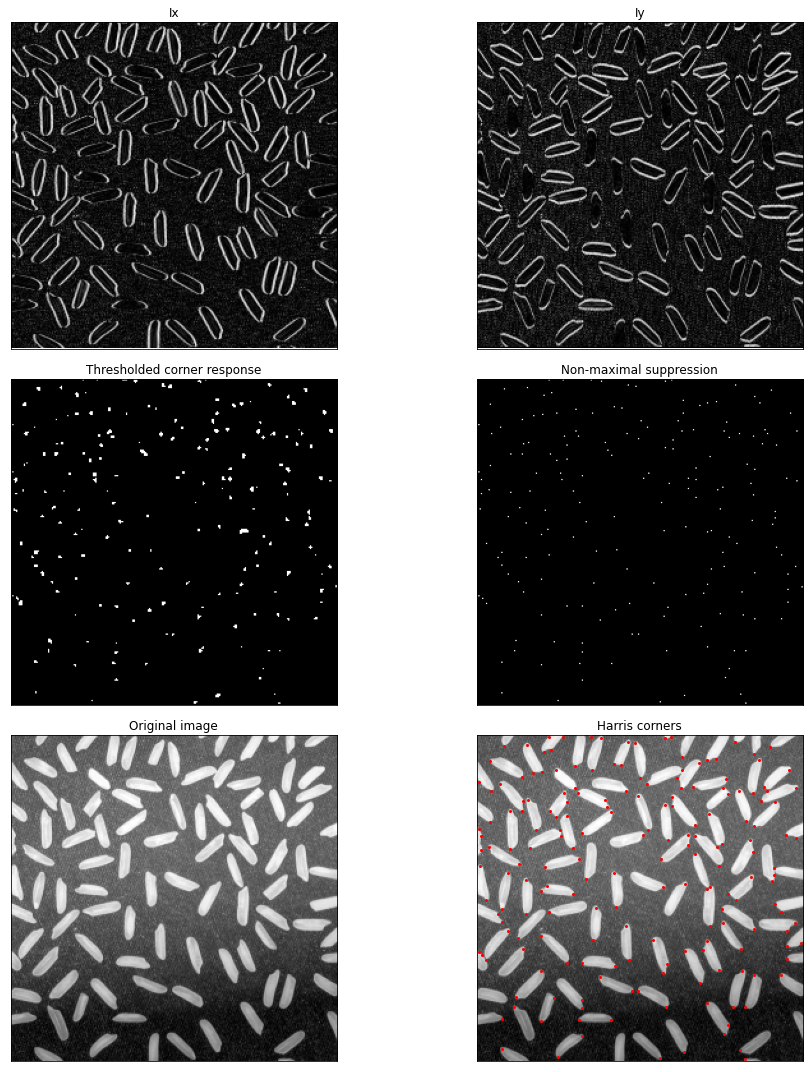

In [45]:
plt.figure(figsize=(15, 15))
imgs =  [Ix_8u, Iy_8u, Threshold_mask, mask, image]
titles = ['Ix', 'Iy', 'Thresholded corner response', 'Non-maximal suppression', 'Original image']

for i in range(5):
  plt.subplot(3,2,i+1),plt.imshow(imgs[i],'gray')
  plt.title(titles[i])
  plt.xticks([]),plt.yticks([])

plt.subplot(3,2,6)
plt.imshow(imgs[-1], cmap=plt.cm.gray)
plt.plot(keypoints[:, 1], keypoints[:, 0], color='red', marker='o',
        linestyle='None', markersize=2)
plt.title('Harris corners')
plt.xticks([]),plt.yticks([])
plt.tight_layout()
plt.show()
